In [1]:
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from similarity_utils import obtain_graph, get_similarity_measure, get_similarity_matrix, find_shortest_path
from parser_with_lane import get_info_from_bpmn_file, write_mer_file
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

c:\Users\maria\anaconda3\envs\SNA_env\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\maria\anaconda3\envs\SNA_env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# PER OGNI PROCESSO (G)
# endsPath_G, startPaths_G = computesShertestPaths(G)
# embeddings_G = calcoalEmbeddingsDiOgniNOdo(G)
# gData[Gid]['graph'] = G
# gData[Gid]['ends'] = endsPath_G;
# gData[Gid]['start'] = startPaths_G;
# gData[Gid]['embeddings'] = embeddings_G;




# for (i,j) ... 
# label_similarity  = computeSimiliarityType(gdata(i)['embeddings'], gdata(j)['embeddings'] )
# type_similarity  = computeSimiliarityType(gdata(i)['graph'], gdata(j)['graph'] )
# weighted_similarity_matrix = (0.4 * label_similarity +
#                         0.2 * type_similarity + .....

# metrica (xmlA, xmlB) = metrica (toGdata(toG(xmlA)), toGdata(toG(xmlB)))
# metrica (marbleA, marbleB) = metrica (toGdata(toG(marbleA)), toGdata(toG(marbleB)))
# metrica (gDataA, gDataB)


# typeSimilarityMatrix =  computeSimiliarityType(G1, G2)
# labelSimilarityMatrix = computeLabelSimilarity(embeddings_G1, embeddings_G2)


# endPathSimilarityMatrix = f(endPath_G1, end_path_G2)
# startPathSimilarityMatrix = f(startPath_G1, startPath_G2)

In [20]:
def load_bpmn_files_from_one_folder(folder_path):
    # List all files in the given folder
    files = []
    for root, _, filenames in os.walk(folder_path):
        for filename in filenames:
            # Join root and filename to get the full file path
            files.append(os.path.join(root, filename))
    bpmn_files = [file for file in files if file.endswith('.bpmn')]
    return bpmn_files


In [2]:
def load_bpmn_files_from_folders(base_path, subset_size=4):

    """""
    Load all BPMN files from a random subset of folders in the base directory.  
    """""
    folders = {}
    # List all folders in the base directory
    all_folders = [folder_name for folder_name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder_name))]
    
    # Select a random subset of 12 folders
    selected_folders = random.sample(all_folders, min(subset_size, len(all_folders)))

    # Load files from the selected folders
    for folder_name in selected_folders:
        folder_path = os.path.join(base_path, folder_name)
        files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        folders[folder_name] = files
        all_files = [file for folder in folders.values() for file in folder]
        bpmn_files = [file for file in all_files if file.endswith('.bpmn')]

    return bpmn_files

In [3]:
all_files = load_bpmn_files_from_folders("cleaned_data", subset_size=2)

In [4]:
def build_process_info_dict(all_files, model):
    files_info = {}
    for file in all_files:
        edge_df, lane_info = get_info_from_bpmn_file(file)  # Unpack the tuple
        graph = obtain_graph(edge_df)
        shortest_path_start, shortest_path_end = find_shortest_path(graph)
        embeddings = {node: model.encode(graph.nodes[node]['name'], convert_to_tensor=True) for node in graph.nodes}
        degree = {node: (graph.in_degree(node), graph.out_degree(node)) for node in graph.nodes}
        files_info[file] = {
            'edge_df': edge_df,   # Assign to 'edge_df' key
            'lane_info': lane_info, # Assign to 'lane_info' key 
            'G' : graph, # Assign to 'graph' key
            'start_shortest_path' : shortest_path_start, # Assign to 'startShortestPath' key
            'end_shortest_path' : shortest_path_end, # Assign to 'endShortestPath' key
            'embeddings' : embeddings, # Assign to 'embeddings' key
            'degree' : degree # Assign to 'degree' key
        }
    return files_info


In [5]:
files_info = build_process_info_dict(all_files, model)

In [6]:
def get_TypeSimilarityMatrix(graph1, graph2, degree_graph1, degree_graph2):
    """""
    Compute the similarity between the types of two nodes.
    """""
    type_similarity = np.zeros((len(graph1.nodes), len(graph2.nodes)))

    for i, node_i in enumerate(graph1.nodes):
        node_i_type = graph1.nodes[node_i]['type']
        node_i_general_type = graph1.nodes[node_i]['general_type']
        in_degree_i, out_degree_i = degree_graph1[node_i]

        for j, node_j in enumerate(graph2.nodes):
            # Compute type similarity
            if node_i_type == graph2.nodes[node_j]['type']:
                type_similarity[i, j] = 1
            elif node_i_general_type == graph2.nodes[node_j]['general_type']:
                type_similarity[i, j] = 0.5
                # Additional gateway checks
                in_degree_j, out_degree_j = degree_graph2[node_j]
                if node_i_general_type == 'gateway' and in_degree_i == in_degree_j and out_degree_i == out_degree_j:
                    type_similarity[i, j] += 0.25
                
    return type_similarity

In [7]:
def get_LabelSimilarityMatrix(embedding1, embedding2):
    label_similarity_matrix = np.zeros((len(embedding1), len(embedding2)))

    for i, node_i in enumerate(embedding1):
        embedding_i = embedding1[node_i]
        for j, node_j in enumerate(embedding2):
            embedding_j = embedding2[node_j]
            label_similarity_matrix[i, j] = util.pytorch_cos_sim(embedding_i, embedding_j).item()
    return label_similarity_matrix

In [8]:
def get_ShortestPathDistanceMatrix(shortest_path_G1, shortest_path_G2):
    # Convert the shortest path dicts to numpy arrays for faster operations
    sp_G1_values = np.array(list(shortest_path_G1.values()))
    sp_G2_values = np.array(list(shortest_path_G2.values()))

    # Create a grid of differences and maximum values
    diff = np.abs(sp_G1_values[:, np.newaxis] - sp_G2_values)
    max_val = np.maximum(sp_G1_values[:, np.newaxis], sp_G2_values)

    shortest_path_distance = 1 - (diff / max_val)
    return shortest_path_distance

In [9]:
def getSimilarity(file_i, file_j, return_matrix=False):

    # Calculate the different similarity metrics
    type_similarity = get_TypeSimilarityMatrix(file_i['G'], file_j['G'], file_i['degree'], file_j['degree'])
    label_similarity = get_LabelSimilarityMatrix(file_i['embeddings'], file_j['embeddings'])
    start_shortest_path_distance = get_ShortestPathDistanceMatrix(file_i['start_shortest_path'], file_j['start_shortest_path'])
    end_shortest_path_distance = get_ShortestPathDistanceMatrix(file_i['end_shortest_path'], file_j['end_shortest_path'])
    
    # Combine the similarities with the given weights
    similarity_matrix = (
        0.4 * label_similarity + 
        0.2 * type_similarity + 
        0.2 * start_shortest_path_distance + 
        0.2 * end_shortest_path_distance
    )

    max_row_mean = np.max(similarity_matrix, axis=1).mean()
    max_col_mean = np.max(similarity_matrix, axis=0).mean()
    similarity_score = (max_row_mean + max_col_mean) / 2

    if return_matrix:
        return similarity_matrix, similarity_score
    else:
        return similarity_score


In [26]:
def get_AllFilesSimilarity(files_info):
    # Initialize the similarity matrix with zeros
    num_files = len(files_info)
    all_files_similarity_matrix = np.zeros((num_files, num_files))
    
    # Get the list of keys in files_info to index into the dictionary
    file_keys = list(files_info.keys())
    
    # Loop over the file keys to compare each file with every other file
    for i in range(num_files):
        for j in range(i, num_files):
            file_i = files_info[file_keys[i]]
            file_j = files_info[file_keys[j]] 
            
            if i == j:
                # Set the diagonal value to 1 (self-similarity)
                all_files_similarity_matrix[i, i] = 1
            else:
                # Compute the overall similarity and fill the symmetric matrix
                all_files_similarity_matrix[i, j] = getSimilarity(file_i, file_j)
                all_files_similarity_matrix[j, i] = all_files_similarity_matrix[i, j]

    return all_files_similarity_matrix
        

In [18]:
def plot_AllFilesSimilarity(all_files_similarity_matrix):
    # Plot the similarity matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(all_files_similarity_matrix, annot=True, fmt=".2f", cmap='YlGn', xticklabels=all_files, yticklabels=all_files)
    plt.title("Weighted Similarity Matrix")
    plt.show()

In [27]:
all_files_similarity_matrix = get_AllFilesSimilarity(files_info)

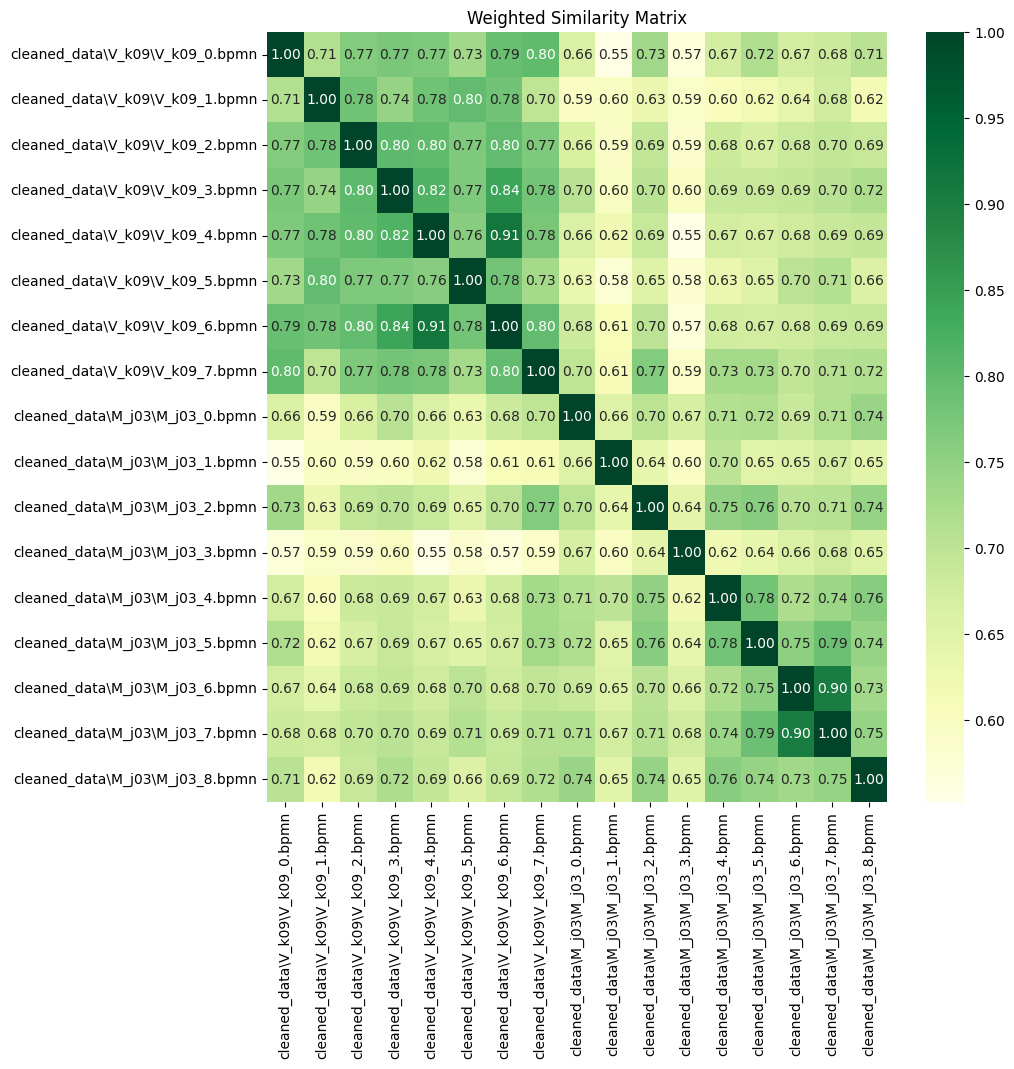

In [28]:
plot_AllFilesSimilarity(all_files_similarity_matrix)

In [16]:
new_file = "cleaned_data/G_g01/G_g01_7.bpmn"


In [21]:
new_file_info = build_process_info_dict([new_file], model)

In [ ]:
# Calculate the different similarity metrics
type_similarity = get_TypeSimilarityMatrix(new_file_info['G'], new_file_info['G'], new_file_info['degree'], new_file_info['degree'])
label_similarity = get_LabelSimilarityMatrix(new_file_info['embeddings'], new_file_info['embeddings'])
start_shortest_path_distance = get_ShortestPathDistanceMatrix(new_file_info['start_shortest_path'], new_file_info['start_shortest_path'])
end_shortest_path_distance = get_ShortestPathDistanceMatrix(new_file_info['end_shortest_path'], new_file_info['end_shortest_path'])
    

1 2
1 3
2 3
